# Entrega final de proyecto parte 2: Entrenamiento, evaluación y optimización de modelos de Machine Learning

En el presente desafío seguiremos utilizando la base de información usual de transacciones o pedidos realizados en un negocio de Ecommerce tradicional enfocado a la venta de mercancíás generales.

El objetivo del proyecto es poder crear un modelo que nos permita predecir el Churn del cliente, es decir, si nos terminará realizando una compra para un periodo particular.

Utilizarémos múltiples** modelos de Machine Learning** para seleccionar aquel con el mejor performance en términos de** precision - recall y F1 Score**. También, utilizarémos métodos de **validacion cruzada** para la evaluación de **overfitting** del modelo y la técnica de tuneo de **Hiperparámetros Grid Search CV** para encontrar los parámetros que guíen a nuestro modelos al mejor performance de **precisión** y **accuracy**. 

In [1]:
#Configuración y lectura de datos. También imprimimos una muestra de las columnas para ver como se estructura la información. 
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.style.use("bmh")
warnings.filterwarnings("ignore")

route = "C:/Users/abrah/Documents/"

df = pd.read_csv(route + "Ecommerce_Transactions_2021.csv", sep = '|', encoding = 'UTF8') #Leemos nuestros datos através de un archivo CSV e imprimios las columnas contenidas así como su data type que manejan por default.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16692886 entries, 0 to 16692885
Data columns (total 98 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   Unnamed: 0                            int64  
 1   Almacen de Origen                     object 
 2   Almacen detalle                       object 
 3   banco                                 object 
 4   Bandera bundle final                  object 
 5   Bandera CBT                           object 
 6   Bandera pagos                         object 
 7   canal                                 object 
 8   Canal_formato_SO                      object 
 9   cantidad                              int64  
 10  Carrier                               object 
 11  CATEGORIA                             object 
 12  Categoria ecomm                       object 
 13  CLICK AND COLLECT                     object 
 14  codigo postal                         float64
 15  Comision MKP 

In [95]:
df.Order_ID

0           Order_21817173
1           Order_21840860
2           Order_22155310
3           Order_22280040
5           Order_22296212
                 ...      
16692881    Order_22332445
16692882    Order_22332592
16692883    Order_22332628
16692884    Order_22332628
16692885    Order_22332628
Name: Order_ID, Length: 13123660, dtype: object

## Feature Engineering

En el siguiente proceso, creamos nuevos campos o features adicionales sobre la base oríginal, tratamos los tipos de datos de algúnas variables y agrupamos nuestra base de informacción orifinal a **nivel cliente** con cada uno de los campos señalados.

In [2]:
## Transforma los tipos de datos oríginales de las distintas variables a los tipos que necesitamos para manipular la información. 
df["FECHA DE CREACION"] = pd.to_datetime(df["FECHA DE CREACION"], format  = "%Y-%m-%d")
df["Fecha de confirmacion"] = pd.to_datetime(df["Fecha de confirmacion"], format  = "%Y-%m-%d")
df["Fecha de cancelacion"] = pd.to_datetime(df["Fecha de cancelacion"], format  = "%Y-%m-%d")
df["FECHA DE CREACION CON HORA"] = pd.to_datetime(df["FECHA DE CREACION CON HORA"],format= '%Y-%m-%d %H:%M:%S')
#df["fecha de embarque"] = pd.to_datetime(df["fecha de embarque"], format  = "%Y-%m-%d")
#df["Fecha de entrega"] = pd.to_datetime(df["Fecha de entrega"], format  = "%Y-%m-%d")
#df["Fecha maxima de entrega"] = pd.to_datetime(df["Fecha maxima de entrega"], format  = "%Y-%m-%d")
#df["Fecha minima de entrega"] = pd.to_datetime(df["Fecha minima de entrega"], format  = "%Y-%m-%d")

df["Año"] = df["FECHA DE CREACION"].dt.year
df["Mes"] = df["FECHA DE CREACION"].dt.month
df["Dia"] = df["FECHA DE CREACION"].dt.day

#Simple imputting process. 
df["Venta bruta sin descuentos con flete"] = df["Venta bruta sin descuentos con flete"].fillna(0)
df["cantidad"] = df["cantidad"].fillna(0)
df["Piezas canceladas"] = df["Piezas canceladas"].fillna(0)
df["Venta cancelada"] = df["Venta cancelada"].fillna(0)
df["Total_venta"] = df["Venta bruta sin descuentos con flete"] + df["Venta cancelada"]
df["Total_piezas"] = df["Piezas canceladas"] + df["cantidad"]

In [3]:
# Filtramos la información de un año hacía atrás, es decir, de Junio 2022 hasta Mayo 2023. También, consideramos solo aquellos pedidos que tuvieron un pago confirmado.
#df = df.loc[df.loc[:,"FECHA DE CREACION"] > "2022-06-01",:]
df = df.loc[df.loc[:,"Fecha de confirmacion"].notna(),:]

In [4]:
df_customer = df.groupby(["FECHA DE CREACION","Año","Mes","Customer_ID","Order_ID"]).agg({'Total_venta': np.sum,'Total_piezas': np.sum}).reset_index()
df_customer.head(10) #Imprimimos nuestra base de información resultante.

,FECHA DE CREACION,Año,Mes,Customer_ID,Order_ID,Total_venta,Total_piezas
0,2021-01-01,2021,1,C1000395,Order_6601912,11620.690000,2.0
1,2021-01-01,2021,1,C1002490,Order_6600223,5765.510000,1.0
2,2021-01-01,2021,1,C1003767,Order_6553751,5170.697928,2.0
3,2021-01-01,2021,1,C1004681,Order_6603468,9849.140000,1.0
4,2021-01-01,2021,1,C100613,Order_6600045,775.001034,1.0
5,2021-01-01,2021,1,C1007224,Order_6602121,1119.831034,1.0
6,2021-01-01,2021,1,C1009042,Order_6599055,2372.413103,1.0
7,2021-01-01,2021,1,C1012964,Order_6603997,2697.360000,1.0
8,2021-01-01,2021,1,C1014466,Order_6597681,1033.621034,1.0
9,2021-01-01,2021,1,C1014610,Order_6603470,5594.830000,1.0


Nueva estructura de df_customer

In [5]:
#Renombramos los campos o columnas para tener mejor estructura de nuestra base de información.
df_customer = df.groupby(["FECHA DE CREACION","Año","Mes","Customer_ID","Order_ID"]).agg({'Total_venta': np.sum, 'Total_piezas': np.sum,
        'Venta bruta sin descuentos con flete': np.sum, 'Flete': np.sum, 'Total descuentos': np.sum, 'Venta cancelada': np.sum, 'Piezas canceladas':np.sum}).reset_index()

df_customer.rename(columns={'FECHA DE CREACION':'Fecha','Total_venta':"Venta",'Total_piezas': "Piezas",'Venta bruta sin descuentos con flete': 'Venta_pagada','Flete':'Costo_envio'
,'Total descuentos':'Total_descuentos','Venta cancelada':'Venta_cancelada'
,'Piezas canceladas':'Piezas_canceladas'}, inplace=True)

df_customer.head(10)

,Fecha,Año,Mes,Customer_ID,Order_ID,Venta,Piezas,Venta_pagada,Costo_envio,Total_descuentos,Venta_cancelada,Piezas_canceladas
0,2021-01-01,2021,1,C1000395,Order_6601912,11620.690000,2.0,11620.690000,0.000000,3032.76,0.0,0.0
1,2021-01-01,2021,1,C1002490,Order_6600223,5765.510000,1.0,5765.510000,84.480000,0.00,0.0,0.0
2,2021-01-01,2021,1,C1003767,Order_6553751,5170.697928,2.0,5170.697928,0.004828,1706.90,0.0,0.0
3,2021-01-01,2021,1,C1004681,Order_6603468,9849.140000,1.0,9849.140000,0.000000,0.00,0.0,0.0
4,2021-01-01,2021,1,C100613,Order_6600045,775.001034,1.0,775.001034,0.001034,301.72,0.0,0.0
5,2021-01-01,2021,1,C1007224,Order_6602121,1119.831034,1.0,1119.831034,0.001034,0.00,0.0,0.0
6,2021-01-01,2021,1,C1009042,Order_6599055,2372.413103,1.0,2372.413103,0.003103,0.00,0.0,0.0
7,2021-01-01,2021,1,C1012964,Order_6603997,2697.360000,1.0,2697.360000,119.780000,344.83,0.0,0.0
8,2021-01-01,2021,1,C1014466,Order_6597681,1033.621034,1.0,1033.621034,0.001034,431.04,0.0,0.0
9,2021-01-01,2021,1,C1014610,Order_6603470,5594.830000,1.0,5594.830000,0.000000,1731.89,0.0,0.0


### Cálculo de variables: Age, Recency , Frequency & Monetary value (RFM)

Para el cálculo del Churn, se utilizará un modelo recursivo de RFM, es decir, iterarémos sobre cada una de las fechas de corte del algoritmo para obtener las variables del modelo de RFM antes de la fecha de corte establecida y tomaremos aquellos cleintes con engagemente para los cuales hayan realizado una compra **un trimestre después**.

Antes tener nuestra base de información original, mostraremos algunas reglas de cálculo de las variables del RFM.

#### Recency

In [6]:
cut_off = df_customer.loc[:,"Fecha"].max()
recency = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off, :].copy()

recency = recency.groupby(["Customer_ID"]).agg({'Fecha':'max'}).reset_index().rename(columns={"Fecha":"LastPurchaseDate"})
recency["Recency"] = ((cut_off - recency.LastPurchaseDate).dt.days)
recency.head()

,Customer_ID,LastPurchaseDate,Recency
0,C100000,2023-06-06,4
1,C1000000,2023-06-04,6
2,C1000011,2023-03-02,100
3,C1000017,2023-03-27,75
4,C1000021,2022-11-04,218


#### Purchase Frequency

In [17]:
cut_off = df_customer.Fecha.max()
frequency = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off,:].copy()
frequency.drop(columns=["Año","Mes"], inplace=True)

frequency.set_index("Fecha", inplace=True)
frequency.index = pd.DatetimeIndex(frequency.index)

frequency_t = frequency.groupby(["Customer_ID", pd.Grouper(freq="M", level="Fecha")]).count()
frequency_t["value_column"] = 1

frequency_t = frequency_t.groupby(["Customer_ID"]).sum().reset_index().rename(columns={'value_column':'Frequency'})

frequency_t = frequency_t.loc[:,["Customer_ID","Frequency"]]
frequency_t.head()


,Customer_ID,Frequency
0,C100000,6
1,C1000000,3
2,C1000011,1
3,C1000017,2
4,C1000021,1


#### Monetary Value

In [18]:
cut_off = df_customer.Fecha.max()
mvalue = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off,:].copy()
mvalue.drop(columns=["Año","Mes"], inplace=True)

#Set date columns as index.
mvalue.set_index(mvalue.Fecha, inplace=True)
mvalue.index = pd.DatetimeIndex(mvalue.index)

mvalue_avg = mvalue.groupby(["Customer_ID"])["Venta"].mean().reset_index().rename(columns={"Venta":'Average_sales'})
mvalue_total = mvalue.groupby(["Customer_ID"])["Venta"].sum().reset_index().rename(columns={"Venta":'Total_sales'})

mvalue = pd.concat([mvalue_avg, mvalue_total], axis=1)
mvalue = mvalue.loc[:,["Customer_ID","Average_sales","Total_sales"]]

mvalue.head()

,Customer_ID,Customer_ID,Average_sales,Total_sales
0,C100000,C100000,5839.516310,58395.163103
1,C1000000,C1000000,11545.139540,34635.418621
2,C1000011,C1000011,3792.230000,3792.230000
3,C1000017,C1000017,2046.551379,4093.102759
4,C1000021,C1000021,6430.167241,6430.167241


#### Age

In [19]:
cut_off = df_customer.Fecha.max()
age = df_customer.loc[df_customer.loc[:,"Fecha"] < cut_off,:].copy()
age.drop(columns=["Año","Mes"], inplace=True)

age = age.groupby(["Customer_ID"])["Fecha"].min().reset_index()
age["age"] = (cut_off - age.Fecha).dt.days

age.head()

,Customer_ID,Fecha,age
0,C100000,2022-11-16,206
1,C1000000,2022-08-27,287
2,C1000011,2023-03-02,100
3,C1000017,2022-07-30,315
4,C1000021,2022-11-04,218


#### Definición de funciones para el cálculo de los atributos del modelo RFM y Otras variables adicionales para el cálculo del Churn 

Dado que tenemos un proceso iterativo que irá calculando dichas features entre periodos, se construye una función que permita obtener una base con estas características ya calculadas.

Las funciones que se construyeron son las siguientes:

In [6]:
def customer_recency(df_customer, cut_off):
    #cut_off = df.loc[:,"Fecha"].max()
    recency = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off, :].copy()
    recency = recency.groupby(["Customer_ID"]).agg({'Fecha':'max'}).reset_index().rename(columns={"Fecha":"LastPurchaseDate"})
    recency["Recency"] = ((cut_off - recency.LastPurchaseDate).dt.days)

    return recency.loc[:,["Customer_ID","Recency"]]

def customer_frequency_1(df_customer, cut_off):

    frequency = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    frequency.drop(columns=["Año","Mes"], inplace=True)

    frequency.set_index("Fecha", inplace=True)
    frequency.index = pd.DatetimeIndex(frequency.index)

    frequency_t = frequency.groupby(["Customer_ID", pd.Grouper(freq="M", level="Fecha")]).count()
    frequency_t["value_column"] = 1

    return frequency_t.groupby(["Customer_ID"]).sum().reset_index().rename(columns={'value_column':'Frequency'}).loc[:,["Customer_ID","Frequency"]]

def customer_frequency(df_customer, cut_off):

    frequency = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    frequency.drop(columns=["Año","Mes"], inplace=True)

    frequency = frequency.groupby(["Customer_ID"]).agg({'Order_ID':lambda x: x.nunique()}).reset_index().rename(columns = {'Order_ID':'Frequency'})

    return frequency.loc[:,["Customer_ID","Frequency"]]

def customer_monetaryvalue(df_customer, cut_off):

    mvalue = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    mvalue.drop(columns=["Año","Mes"], inplace=True)

    mvalue.set_index(mvalue.Fecha, inplace=True)
    mvalue.index = pd.DatetimeIndex(mvalue.index)

    mvalue_avg = mvalue.groupby(["Customer_ID"])["Venta"].mean().reset_index().rename(columns={"Venta":'Average_sales'})
    mvalue_total = mvalue.groupby(["Customer_ID"])["Venta"].sum().reset_index().rename(columns={"Venta":'Total_sales'})

    mvalue = pd.concat([mvalue_avg, mvalue_total], axis=1)
    mvalue = mvalue.loc[:,["Customer_ID","Average_sales","Total_sales"]]
    
    return mvalue.iloc[:,1:]
    
def customer_age(df_customer, cut_off):
    
    age = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    age.drop(columns=["Año","Mes"], inplace=True)

    age = age.groupby(["Customer_ID"])["Fecha"].min().reset_index()
    age["Age"] = (cut_off - age.Fecha).dt.days
 
    return age.loc[:,["Customer_ID","Age"]]

def customer_cancellations(df_customer, cut_off):
    df_cancellations = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_cancellations.drop(columns=["Año","Mes"], inplace=True)

    df_cancellations = df_cancellations.groupby(["Customer_ID"])["Piezas","Piezas_canceladas"].sum().reset_index()
    df_cancellations.loc[:,"Ratio_cancellations"] = df_cancellations.Piezas_canceladas / df_cancellations.Piezas 
    
    return df_cancellations.loc[:,["Customer_ID","Ratio_cancellations"]]
    
def customer_basket_size(df_customer, cut_off):
    df_bs = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_bs.drop(columns=["Año","Mes"], inplace=True)

    df_bs = df_bs.groupby(["Customer_ID"]).agg({'Piezas': np.sum , 'Order_ID': lambda x: x.nunique()}).reset_index().rename(columns = {'Order_ID':'Ordenes'})
    df_bs.loc[:,"Basket_size"] = df_bs.Piezas / df_bs.Ordenes 
    
    return df_bs.loc[:,["Customer_ID","Basket_size"]]

def customer_shipping_ratio(df_customer, cut_off):
    df_sr = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_sr.drop(columns= ["Año","Mes"], inplace=True)

    df_sr = df_sr.groupby(["Customer_ID"]).agg({'Costo_envio': np.sum,'Venta_pagada': np.sum}).reset_index()
    df_sr.loc[:,"Shipping_ratio"] = df_sr.Costo_envio / df_sr.Venta_pagada 
    
    return df_sr.loc[:,["Customer_ID","Shipping_ratio"]]

def customer_discount_ratio(df_customer, cut_off):
    df_dr = df_customer.loc[df_customer.loc[:,"Fecha"] <= cut_off,:].copy()
    df_dr.drop(columns= ["Año","Mes"], inplace=True)

    df_dr = df_dr.groupby(["Customer_ID"]).agg({'Total_descuentos': np.sum,'Venta_pagada': np.sum}).reset_index()
    df_dr.loc[:,"Discount_ratio"] = df_dr.Total_descuentos / (df_dr.Venta_pagada + df_dr.Total_descuentos) 
    
    return df_dr.loc[:,["Customer_ID","Discount_ratio"]]

def customer_rfm(df_customer, cut_off):

    recency = customer_recency(df_customer, cut_off)
    frequency = customer_frequency(df_customer, cut_off)
    monetary_value = customer_monetaryvalue(df_customer, cut_off)
    age = customer_age(df_customer, cut_off)
    
    cancellations = customer_cancellations(df_customer, cut_off)
    basket_size = customer_basket_size(df_customer, cut_off)
    shipping_ratio = customer_shipping_ratio(df_customer, cut_off)
    discount_ratio = customer_discount_ratio(df_customer, cut_off)

    return pd.merge(left=recency, right=frequency, how='left', left_on= "Customer_ID", right_on="Customer_ID").merge(monetary_value, on="Customer_ID").merge(age, on = "Customer_ID").merge(cancellations, on = "Customer_ID").merge(basket_size, on = "Customer_ID").merge(shipping_ratio, on = "Customer_ID").merge(discount_ratio, on = "Customer_ID")


Testing de obtención de los atributos del modelo de RFM.

In [7]:
cut_off = df_customer.Fecha.max()
rfm_features = customer_rfm(df_customer, cut_off)

In [8]:
#Imprime un sample de como luce la información. 
rfm_features

,Customer_ID,Recency,Frequency,Average_sales,Total_sales,Age,Ratio_cancellations,Basket_size,Shipping_ratio,Discount_ratio
0,C1,576,1,128.450000,128.450000,576,0.0,1.000000,0.000000e+00,0.850849
1,C10000,630,1,9481.892759,9481.892759,630,0.0,1.000000,2.909357e-07,0.120010
2,C100000,4,10,5839.516310,58395.163103,206,0.0,1.300000,7.986674e-03,0.283161
3,C1000000,6,7,7309.119409,51163.835862,888,0.0,1.285714,2.325194e-03,0.125778
4,C1000002,417,3,1023.338851,3070.016552,529,0.0,1.666667,2.134101e-06,0.063630
...,...,...,...,...,...,...,...,...,...,...
5430819,C999991,40,3,3785.686207,11357.058621,200,0.0,1.000000,1.039870e-02,0.132363
5430820,C999992,575,1,4134.480000,4134.480000,575,0.0,4.000000,0.000000e+00,0.215826
5430821,C999994,135,2,5619.051724,11238.103448,148,0.0,1.000000,5.983523e-03,0.099461
5430822,C999997,637,1,3987.100000,3987.100000,637,0.0,1.000000,0.000000e+00,0.000003


In [7]:
def churn_label(future):
    future['DidBuy'] = 1
    return future.loc[:,["Customer_ID","DidBuy"]].drop_duplicates()

#### Construcción de la base de información para el entrenamiento del modelo. 

Dentro del siguiente proceso, irémos de manera **trimestral** o por **quarter** construyendo las variables de etiqueta de CHunr a través del campo "DidBuy" y las demás variables del enfoque RFM.

EL propósito de iterar sobre múltiples periodos es para capturar los efectos de temporalidad y estacionalidad que impactan o se reflejan dentro del comportmamiento del cliente. Con esto, realizaríamos un análisis de Churn con múltiples periodos. La frecuencia de análisis se haría de forma mensual y el dataset final es un consolidado con los atributos del RFM y Labels de Chunrn para cada periodo de análisis

El periodo de iteración comprende desde Junio 2022 hasta el 2023, por lo que de manera mensual o mes a mes, irémos calculando las etiqutas de Churn y las caracterías del enfoque del RFM.

Definición de rangos de fechas con 3 Meses

In [9]:
start_length = 90
label_period_days = 90

dset_list = list()

start_date = df_customer.loc[:,["Fecha"]].min() 
end_date = df_customer.loc[:,["Fecha"]].max() 

dates = pd.date_range(start=start_date[0], end=end_date[0], freq='Q')
#df_customer.Fecha = pd.to_datetime(df_customer.Fecha, format = "%Y-%m-%d") 

for cut_off in dates:
    #observed = df_customer.loc[df_customer.Fecha <= cut_off,:]
    future = df_customer.loc[(df_customer.Fecha > cut_off) & (df_customer.Fecha < cut_off + pd.Timedelta(label_period_days, unit='D')),:]

    rfm_sdate = cut_off
    rfm_edate = cut_off + pd.Timedelta(label_period_days, unit='D')

    print(f"Computing rfm features for {cut_off} to {rfm_edate}")

    #Obtenemos las características RFM de los clientes. 
    rfm_features = customer_rfm(df_customer, cut_off)
    labels = churn_label(future)

    dset = pd.merge(left= rfm_features, right=labels, how='outer', left_on="Customer_ID",right_on="Customer_ID").fillna(0)
    dset_list.append(dset)

#Concatenamos todos los datasets
full_dataset = pd.concat(dset_list, axis = 0)
res = full_dataset.loc[full_dataset.Recency != 0,:].dropna(axis = 1, how = 'any')

Computing rfm features for 2021-03-31 00:00:00 to 2021-06-29 00:00:00
Computing rfm features for 2021-06-30 00:00:00 to 2021-09-28 00:00:00
Computing rfm features for 2021-09-30 00:00:00 to 2021-12-29 00:00:00
Computing rfm features for 2021-12-31 00:00:00 to 2022-03-31 00:00:00
Computing rfm features for 2022-03-31 00:00:00 to 2022-06-29 00:00:00
Computing rfm features for 2022-06-30 00:00:00 to 2022-09-28 00:00:00
Computing rfm features for 2022-09-30 00:00:00 to 2022-12-29 00:00:00
Computing rfm features for 2022-12-31 00:00:00 to 2023-03-31 00:00:00
Computing rfm features for 2023-03-31 00:00:00 to 2023-06-29 00:00:00


Imprimimos una muestra de la base final que se consumirá por para de los modelos de ML para la fase de testing y entrenamiento

In [11]:
res

,Customer_ID,Recency,Frequency,Average_sales,Total_sales,Age,Ratio_cancellations,Basket_size,Shipping_ratio,Discount_ratio,DidBuy
0,C1000000,87.0,1.0,1033.610000,1033.610000,87.0,0.0,1.0,0.000000e+00,0.000010,1.0
1,C1000007,80.0,1.0,11874.120000,11874.120000,80.0,0.0,2.0,1.408441e-02,0.153621,0.0
2,C1000020,34.0,1.0,6801.710000,6801.710000,34.0,0.0,1.0,0.000000e+00,0.122360,0.0
3,C1000021,36.0,1.0,4783.623793,4783.623793,36.0,0.0,1.0,7.929351e-07,0.000000,0.0
4,C1000024,53.0,1.0,654.311034,654.311034,53.0,0.0,1.0,1.581026e-06,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4990822,C999991,129.0,1.0,4205.340690,4205.340690,129.0,0.0,1.0,7.994760e-03,0.198719,1.0
4990823,C999992,504.0,1.0,4134.480000,4134.480000,504.0,0.0,4.0,0.000000e+00,0.215826,0.0
4990824,C999994,64.0,2.0,5619.051724,11238.103448,77.0,0.0,1.0,5.983523e-03,0.099461,0.0
4990825,C999997,566.0,1.0,3987.100000,3987.100000,566.0,0.0,1.0,0.000000e+00,0.000003,0.0


## **Entrenamiento de Modelos de Machine Learning**


Antes de pasar al entrenamiento del modelo de ML, se harán algunos procesos adicionales de tratamiento de información como lo es el uso de MinMaxScaler para escalar los datos entre los rango de 1 y 0.

Dado que nuenuestra base de información, en cada una de las variables del enfoque RFM no poseen una distribución normal, se considera usar el procesamiento a través del MinMaxScaler.

Seperando nuestros datos en conjunto de **entrenamiento**, **test** y aplicación de escalamiento de datos (MinMaxScaler).

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

rec_df = res.sample(frac=1)

# Obtenemos la matriz de datos o features y la matriz de respuesta.
X = rec_df.loc[:,["Recency","Frequency","Average_sales","Age","Ratio_cancellations","Basket_size","Shipping_ratio","Discount_ratio"]].values
y = rec_df.loc[:,["DidBuy"]].values.reshape(-1)

#Aplicamos el método fit_transform a través de Min-Max Scaler para  transformar nuestros datos. 
scaler = MinMaxScaler()
X_scale  = scaler.fit_transform(X)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=test_size, random_state=42, shuffle=True)

### SMOTE - Atacando el problema de desbalanceo en nuestra base de información. 
Importante, observemos  lo siguiente:

In [11]:
rec_df.DidBuy.value_counts()

0.0    23247981
1.0     2933452
Name: DidBuy, dtype: int64

Como se observa, alrededor de del 7.8% de las observaciones son aquellos clientes que han realizado una compra en los periodos futuros de observación, mientras que el 92.2% de los cliente no realizaron una compra **(Churn)**

La clase minoría en este caso son los **clientes con compra**.
La clase mayorista eran los **clientes sin compra** o **clientes con Churn**.

Así, tenemos un problema de **clases imbalanceadas**. 

Para atacar el problmea anterior, usarémos una técnica denominada SMOTE (Synthetic Minotiry Oversampling Technique). Lo que harémos es hacer sampling para tener más registros de la clase minorísta , es decir, de aquellos **clientes con compra**. 



In [12]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [13]:
pd.Series(y_train_over).value_counts()

0.0    18599204
1.0    18599204
dtype: int64

Se realizó un oversampling de la clase minoría para así tratar de arreglar el problema de desbalanceo. 

**Nuestra proporción de clases ahora está 50 - 50.**

### **Entrenamiento del 1er modelo de Machine Learning : Decision Trees**

Dentro del siguiente ejercicio, utilizaremos un modelo de arbol de decisión para nuestro problema de clasificación de Churn.

Utilizaremos la medida de 'gini' como criterio de split de información para cada nodo interno hasta alcanzar nodos terminales. Nuestro arbol tendrá un máxima profundidad de 8, el splitter se considera como 'best', y min_sample_split = 8.


In [43]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

clf= DecisionTreeClassifier(
    criterion='gini',
    max_depth=8,
    min_samples_split=8,
    min_samples_leaf=1,
    max_features=None,
    splitter='best',
    random_state=1234
)

clf_no = clf.fit(X_train, y_train) 
clf_wo = clf.fit(X_train_over, y_train_over) 

In [44]:
# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = clf_no.predict(X_train) #Predicciones sobre el training set

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = clf_no.predict(X_test)
predictions_test['preds_over'] = clf_wo.predict(X_test)

#Calculamos el accuracy de los pronósticos
# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")


Accuary datos entrenamiento: 0.7621, Accuracy datos Test: 0.7619, Accuracy test Oversampled: 0.7619


Matríz de confusión sobre datos **sin oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

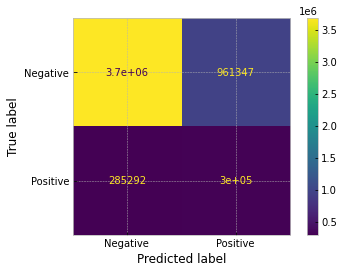

In [45]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(clf_no, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos **con oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

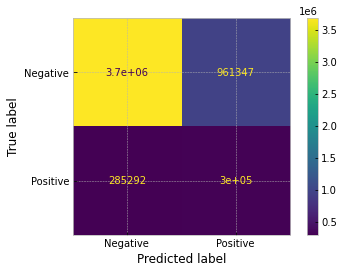

In [46]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(clf_wo, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de performance sobre datos sin **oversampling - SMOTE**

In [47]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86   4648777
         1.0       0.24      0.51      0.33    587510

    accuracy                           0.76   5236287
   macro avg       0.58      0.65      0.59   5236287
weighted avg       0.85      0.76      0.80   5236287



Reporte de performance sobre datos con **oversampling - SMOTE**

In [48]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86   4648777
         1.0       0.24      0.51      0.33    587510

    accuracy                           0.76   5236287
   macro avg       0.58      0.65      0.59   5236287
weighted avg       0.85      0.76      0.80   5236287



**Resultados**

Dataset sin **SMOTE u oversampling**:

Vemos que el accuracy del test set y el training set sin oversampling es de 0.76, mientras que con el oversampling | SMOTE el accuracy es practiamente igual.

No se tiene una diferenciación en los resultados si comparamos la base original contra aquella con SMOTE

Véamos que para este modelo, tenemos buenos índices de recall y precision de la clase "Churn", 0.79 y 0.93 respectivamente. Por otra parte, se observa que el F1 score de la clase 0 es 0.86 y 0.33 para la clase positiva. El modelo presenta mejor performance en términos de recall para la clase positiva, es decir, de 0.51. Por otra parte, en precision quedamos en 0.24 y F1 score con 0.33. Nuestro modelo presentaría oportunidad para identificar a la clase positiva o "No Churn". 

**ROC Curve | Datos con oversampling - SMOTE y Datos sin Oversampling**


0.7060715458622626 0.7060715458622626


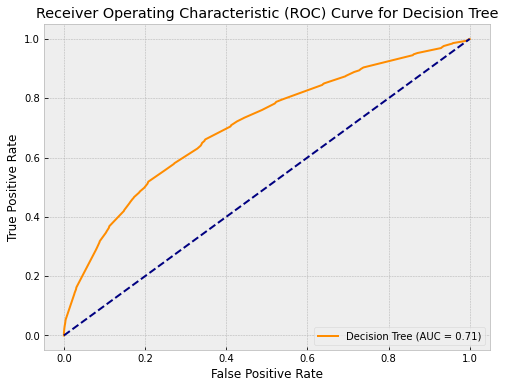

In [49]:
y_scores_tree_no = clf_no.predict_proba(X_test)
y_scores_tree_wo = clf_wo.predict_proba(X_test)


fpr_tree_no, tpr_tree_no, thresholds_tree_no = roc_curve(y_test, y_scores_tree_no[:,1])
roc_auc_tree_no = auc(fpr_tree_no, tpr_tree_no)   # Este es el indicador AUC de la curva ROC

fpr_tree_wo, tpr_tree_wo, thresholds_tree_wo = roc_curve(y_test, y_scores_tree_wo[:,1])
roc_auc_tree_wo = auc(fpr_tree_wo, tpr_tree_wo)   # Este es el indicador AUC de la curva ROC

print(roc_auc_tree_no, roc_auc_tree_wo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_no, tpr_tree_no, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_tree_no:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

El gráfico anterior muestra el indicador **AUC** de la curva **ROC** con un valor de 0.71, lo cual, tiene buen performance en cuanto a la diferenciación de las dos clases: **"Churn"** y **"No Churn"**.

### **Entrenamiento del 2do (a) modelo de Machine Learning : BAGGING METHOD - RANDOM FORESTS**

En este caso, utilizaremos métodos de ensamblaje para entrenar nuestro modelo de Machine Learning y así entrender cuales son los clientes con mayor riesgo de presentar **Churn.**

Este problema es del tipo supervisadO por lo que el Modelo utilizado será el siguiente: **Random Forest**

También, se entrenan dos modelos: Una base con el conjunto de información original y otro con SMOTE aplicado. Esto, para reducir el sesgo producido por el problema de desbalanceo.  

In [51]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

#Entrenamos el modelo sobre la base de información imbalanceada
rf = RandomForestClassifier(random_state=42, n_estimators = 100, criterion = 'entropy', min_samples_split = 3, min_samples_leaf = 2, max_depth = 10).fit(X_train,y_train)

#Entrenamos el modelo sobre la nueva base con la clase minoría con oversampling | SMOTE
rf_over = RandomForestClassifier(random_state=42, n_estimators = 100, criterion = 'entropy', min_samples_split = 3, min_samples_leaf = 2, max_depth = 10).fit(X_train_over, y_train_over)

#### Evaluación del Modelo de clasificación de Random Forests. 

Accuracy assessment: En base al modelo anterior, harémos las predicciones correspondiente sobre el dataset de muestra y training y así revisar **Accuracy** de clasificiación. 

In [52]:
# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = rf.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = rf.predict(X_test)
predictions_test['preds_over'] = rf_over.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.8910, Accuracy datos Test: 0.8908, Accuracy test Oversampled: 0.7471


Matríz de confusión sobre datos sin **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

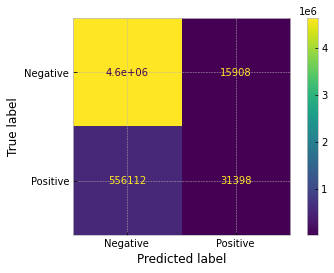

In [53]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(rf, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos con **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

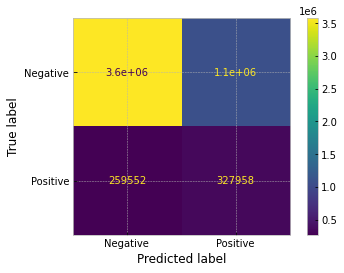

In [54]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(rf_over, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de Precision - Recall - F1 Score | **Datos sin oversampling - SMOTE**


In [55]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   4648777
         1.0       0.66      0.05      0.10    587510

    accuracy                           0.89   5236287
   macro avg       0.78      0.53      0.52   5236287
weighted avg       0.87      0.89      0.85   5236287



Reporte de Precision - Recall - F1 Score | **Datos con oversampling - SMOTE**


In [56]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84   4648777
         1.0       0.24      0.56      0.33    587510

    accuracy                           0.75   5236287
   macro avg       0.58      0.66      0.59   5236287
weighted avg       0.85      0.75      0.79   5236287



**Resultados**

El uso de SMOTE en nuestro modelo de Arboles aleatorios sacrifica performance de precision para la clase positiva, sin emabrgo, aumentamos el recall. También, se observa una mejor de F1 Score para la clase positiva, de 0.10 a 0.33.

El accuracy en SMOTE se castiga, pasando de 0.89 a 0.75. Para este caso, podemos utilizar este modelo con un mayor balanceo a través de SMOTE para la construcción de nuestro modelos de **predicción de Churn**. Se presenta el mismo comportamiento de performance repecto a la variante B.



**ROC Curve | Datos con oversampling - SMOTE y Datos sin Oversampling**

La curva ROC se calculó y graficó, para este caso, con el conjunto de datos **sin Oversampling**.

0.7301736681682739 0.7236803217586222


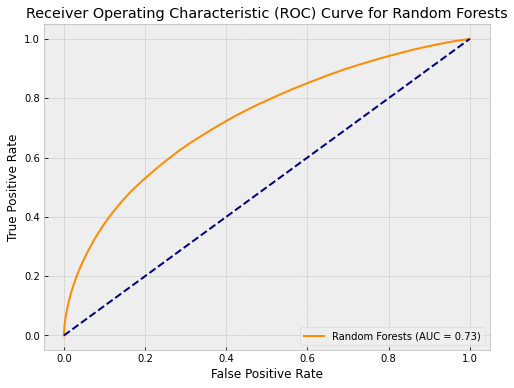

In [57]:
y_scores_tree_no = rf.predict_proba(X_test)
y_scores_tree_wo = rf_over.predict_proba(X_test)

fpr_tree_no, tpr_tree_no, thresholds_tree_no = roc_curve(y_test, y_scores_tree_no[:,1])
roc_auc_tree_no = auc(fpr_tree_no, tpr_tree_no)   # Este es el indicador AUC de la curva ROC

fpr_tree_wo, tpr_tree_wo, thresholds_tree_wo = roc_curve(y_test, y_scores_tree_wo[:,1])
roc_auc_tree_wo = auc(fpr_tree_wo, tpr_tree_wo)   # Este es el indicador AUC de la curva ROC

print(roc_auc_tree_no, roc_auc_tree_wo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_no, tpr_tree_no, color='darkorange', lw=2, label=f'Random Forests (AUC = {roc_auc_tree_no:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forests')
plt.legend(loc='lower right')
plt.show()

El gráfico anterior muestra el indicador **AUC** de la curva **ROC** con un valor de **0.73**, lo cual, tiene buen performance en cuanto a la diferenciación de las dos clases: **"Churn"** y **"No Churn"**.

### **Entrenamiento del 2do (b) modelo de Machine Learning : BAGGING METHOD - RANDOM FORESTS**

In [58]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

#Entrenamos el modelo sobre la base de información imbalanceada
rf = RandomForestClassifier(random_state=42,n_estimators = 200, criterion = 'gini', min_samples_split = 3, min_samples_leaf = 2, max_depth = 7).fit(X_train,y_train)

#Entrenamos el modelo sobre la nueva base con la clase minoría con oversampling | SMOTE
rf_over = RandomForestClassifier(random_state=42,n_estimators = 200, criterion = 'gini', min_samples_split = 3, min_samples_leaf = 2, max_depth = 7).fit(X_train_over, y_train_over)

#### Evaluación del Modelo de clasificación de Random Forests. 

Accuracy assessment: En base al modelo anterior, harémos las predicciones correspondiente sobre el dataset de muestra y training y así revisar **Accuracy** de clasificiación. 

In [59]:
# Guardamos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = rf.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = rf.predict(X_test)
predictions_test['preds_over'] = rf_over.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.8905, Accuracy datos Test: 0.8903, Accuracy test Oversampled: 0.7166


Matríz de confusión sobre datos sin **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

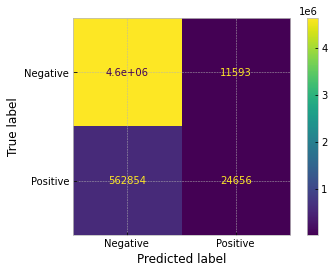

In [60]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(rf, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos con **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

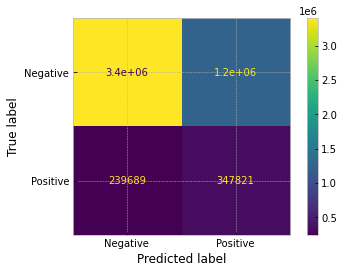

In [61]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(rf_over, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de Precision - Recall - F1 Score | **Datos sin oversampling - SMOTE**


In [62]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   4648777
         1.0       0.68      0.04      0.08    587510

    accuracy                           0.89   5236287
   macro avg       0.79      0.52      0.51   5236287
weighted avg       0.87      0.89      0.84   5236287



Reporte de Precision - Recall - F1 Score | **Datos con oversampling - SMOTE**


In [63]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.93      0.73      0.82   4648777
         1.0       0.22      0.59      0.32    587510

    accuracy                           0.72   5236287
   macro avg       0.58      0.66      0.57   5236287
weighted avg       0.85      0.72      0.76   5236287



**Resultados**

El uso de SMOTE en nuestro modelo de Arboles aleatorios sacrifica performance de precision para la clase positiva, sin emabrgo, aumentamos el recall. También, se observa una mejor de F1 Score para la clase positiva, de 0.08 a 0.31.

El accuracy en SMOTE se castiga, pasando de 0.89 a 0.72. Para este caso, podemos utilizar este modelo con un mayor balanceo a través de SMOTE para la construcción de nuestro modelos de **predicción de Churn**. 

**ROC Curve | Datos con oversampling - SMOTE y Datos sin Oversampling**


La curva ROC se calculó y graficó, para este caso, con el conjunto de datos **sin Oversampling**.

0.7275993921462567 0.7212448773056729


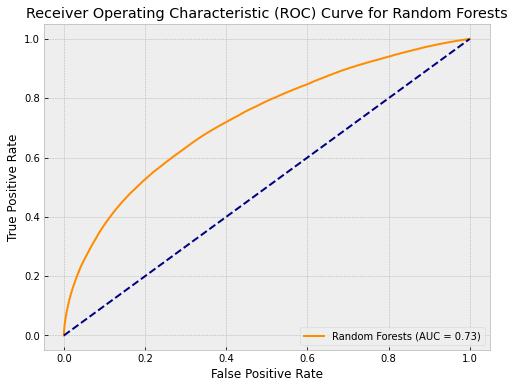

In [64]:
y_scores_tree_no = rf.predict_proba(X_test)
y_scores_tree_wo = rf_over.predict_proba(X_test)

fpr_tree_no, tpr_tree_no, thresholds_tree_no = roc_curve(y_test, y_scores_tree_no[:,1])
roc_auc_tree_no = auc(fpr_tree_no, tpr_tree_no)   # Este es el indicador AUC de la curva ROC

fpr_tree_wo, tpr_tree_wo, thresholds_tree_wo = roc_curve(y_test, y_scores_tree_wo[:,1])
roc_auc_tree_wo = auc(fpr_tree_wo, tpr_tree_wo)   # Este es el indicador AUC de la curva ROC

print(roc_auc_tree_no, roc_auc_tree_wo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_no, tpr_tree_no, color='darkorange', lw=2, label=f'Random Forests (AUC = {roc_auc_tree_no:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forests')
plt.legend(loc='lower right')
plt.show()

El gráfico anterior muestra el indicador **AUC** de la curva **ROC** con un valor de 0.73, lo cual, tiene buen performance en cuanto a la diferenciación de las dos clases: **"Churn"** y **"No Churn"**.

### **Entrenamiento del 3er (a) modelo de Machine Learning : BOOSTING METHODS - XGBoost**

In [65]:
import xgboost as xgb

xgb_model =  xgb.XGBClassifier(n_estimators = 100, learning_rate = 0.1, random_state = 42, max_depth = 6)

#Entrenamiento del modelo sobre información sin oversampling.
xgb_model_no = xgb_model.fit(X_train, y_train)

#Entrenamiento del modelo con oversampling | SMOTE
xgb_model_wo = xgb_model.fit(X_train_over, y_train_over)


#### Evaluación del Modelo de clasificación de XGBoost. 

In [66]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = xgb_model_no.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = xgb_model_no.predict(X_test)
predictions_test['preds_over'] = xgb_model_wo.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.8343, Accuracy datos Test: 0.8340, Accuracy test Oversampled: 0.8340


Matríz de confusión sobre datos **sin oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

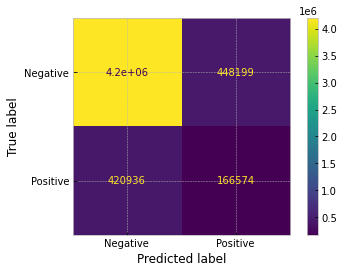

In [67]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_no, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos **con oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

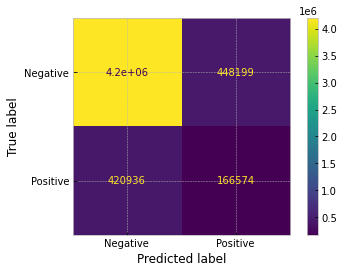

In [68]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_wo, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de performance sobre datos sin **oversampling - SMOTE**

In [69]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91   4648777
         1.0       0.27      0.28      0.28    587510

    accuracy                           0.83   5236287
   macro avg       0.59      0.59      0.59   5236287
weighted avg       0.84      0.83      0.84   5236287



Reporte de performance sobre datos con **oversampling - SMOTE**

In [70]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91   4648777
         1.0       0.27      0.28      0.28    587510

    accuracy                           0.83   5236287
   macro avg       0.59      0.59      0.59   5236287
weighted avg       0.84      0.83      0.84   5236287



**Resultados**

El uso de **SMOTE** para el entrenamiento de nuestro modelo no marcó diferencial alguno en términos de precision, reacll y f1-score.

Nuestro modelo de **XBGboost** bajo la **variante A** presenta un buen performance en términos de precisión, **83%** , mientras que el F-Score de la clase negativo se mantiene en **0.92** y de la clases positiva **0.28**. El rendimiento en términos de F1 score para la clase 1 no es el mejor si se compara contra otros modelos. Por otra parte, presenta un mejor **rendimiento en F1 score** de clase positiva respecto a la **variante B**.  


**ROC Curve | Datos con oversampling - SMOTE y Datos sin Oversampling**


0.6756401467163299 0.6756401467163299


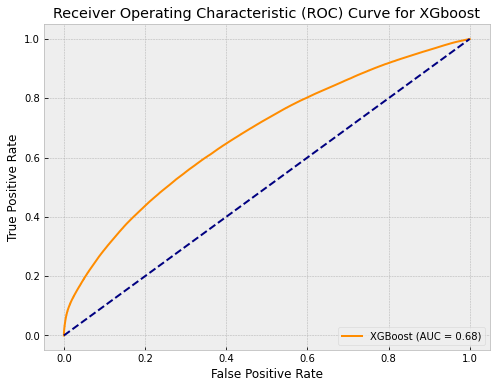

In [71]:
y_scores_tree_no = xgb_model_no.predict_proba(X_test)
y_scores_tree_wo = xgb_model_wo.predict_proba(X_test)

fpr_tree_no, tpr_tree_no, thresholds_tree_no = roc_curve(y_test, y_scores_tree_no[:,1])
roc_auc_tree_no = auc(fpr_tree_no, tpr_tree_no)   # Este es el indicador AUC de la curva ROC

fpr_tree_wo, tpr_tree_wo, thresholds_tree_wo = roc_curve(y_test, y_scores_tree_wo[:,1])
roc_auc_tree_wo = auc(fpr_tree_wo, tpr_tree_wo)   # Este es el indicador AUC de la curva ROC

print(roc_auc_tree_no, roc_auc_tree_wo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_no, tpr_tree_no, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc_tree_no:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGboost')
plt.legend(loc='lower right')
plt.show()

El gráfico anterior muestra el indicador **AUC** de la curva **ROC** con un valor de 0.68, lo cual, tiene buen performance en cuanto a la diferenciación de las dos clases: **"Churn"** y **"No Churn"**. Por otra parte, presenta menor performance en comparación con los métodos de **Bagging**, en este caso, para **Random Forests**.

### **Entrenamiento del 3er (b) modelo de Machine Learning : BOOSTING METHODS - XGBoost**

In [72]:
import xgboost as xgb

#Entrenamos el modelo sobre la base de información imbalanceada
xgb_model =  xgb.XGBClassifier(n_estimators = 200, learning_rate = 0.5, random_state = 42, max_depth = 8)

#Entrenamiento sobre 
xgb_model_no = xgb_model.fit(X_train, y_train)

#Datos con oversampling.
xgb_model_wo = xgb_model.fit(X_train_over, y_train_over)


#### Evaluación del Modelo de clasificación de XGBoost. 

In [73]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = xgb_model_no.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = xgb_model_no.predict(X_test)
predictions_test['preds_over'] = xgb_model_wo.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.8617, Accuracy datos Test: 0.8600, Accuracy test Oversampled: 0.8600


Matríz de confusión sobre datos **sin oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

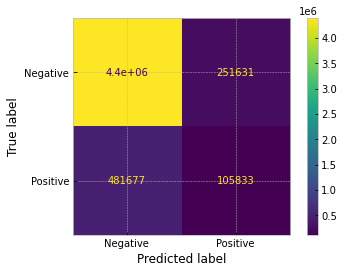

In [74]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_no, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos **con oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

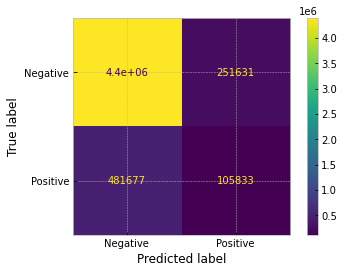

In [75]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_wo, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de performance de métricas sobre datos sin **oversampling - SMOTE**

In [76]:
#Imprimimos todas las métricas en 1 - Sobre base de información sin algoritmo de SMOTE para atacar desbalanceo
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92   4648777
         1.0       0.30      0.18      0.22    587510

    accuracy                           0.86   5236287
   macro avg       0.60      0.56      0.57   5236287
weighted avg       0.83      0.86      0.84   5236287



Reporte de perofrmance de métricas sobre datos datos con **oversampling - SMOTE**

In [77]:
#Imprimimos todas las métricas en 1 - Sobre base de información sin algoritmo de SMOTE para atacar desbalanceo
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92   4648777
         1.0       0.30      0.18      0.22    587510

    accuracy                           0.86   5236287
   macro avg       0.60      0.56      0.57   5236287
weighted avg       0.83      0.86      0.84   5236287



**Resultados**

El uso de **SMOTE** para el entrenamiento de nuestro modelo no marcó diferencial alguna en términos de precision, reacll y f1-score.

Nuestro modelo de **XBGboost** bajo la **variante B** presenta un buen performance en términos de precisión, **86%** , mientras que el F-Score de la clase negativo se mantiene en **0.92** y de la clases positiva **0.22**. El rendimiento en términos de F1 score para la clase 1 no es el mejor si se compara contra otros modelos.



**ROC Curve | Datos con oversampling - SMOTE y Datos sin Oversampling**


0.6628307775719364 0.6628307775719364


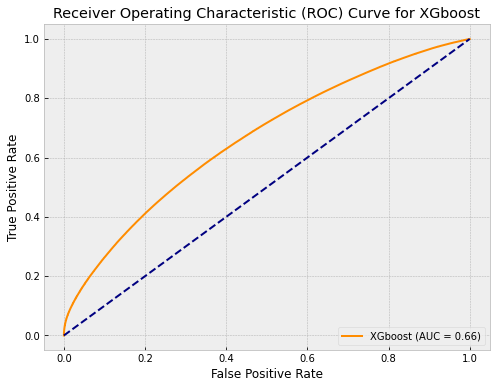

In [78]:
y_scores_tree_no = xgb_model_no.predict_proba(X_test)
y_scores_tree_wo = xgb_model_wo.predict_proba(X_test)


fpr_tree_no, tpr_tree_no, thresholds_tree_no = roc_curve(y_test, y_scores_tree_no[:,1])
roc_auc_tree_no = auc(fpr_tree_no, tpr_tree_no)   # Este es el indicador AUC de la curva ROC

fpr_tree_wo, tpr_tree_wo, thresholds_tree_wo = roc_curve(y_test, y_scores_tree_wo[:,1])
roc_auc_tree_wo = auc(fpr_tree_wo, tpr_tree_wo)   # Este es el indicador AUC de la curva ROC

print(roc_auc_tree_no, roc_auc_tree_wo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_no, tpr_tree_no, color='darkorange', lw=2, label=f'XGboost (AUC = {roc_auc_tree_no:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGboost')
plt.legend(loc='lower right')
plt.show()

El gráfico anterior muestra el indicador **AUC** de la curva **ROC** con un valor de 0.66, lo cual, tiene buen performance en cuanto a la diferenciación de las dos clases: **"Churn"** y **"No Churn"**. De igual manera, presenta menor performance contra la **variante A** de **XGboost** y los modelos de **Random Forests**.  

### **Entrenamiento del 4to modelo de Machine Learning : LOGISTIC REGRESSION**

Para este caso, utilizarémos un modelo de **regresión logística** para comparar el performance de dicho modelo con aquellos del tipo Bagging como Random Forests o del tipo Boosting como **XGboost**. 

Se entrenarán dichos modelos sobre la base total y la base desbalanceada. Para la evaluación mediremos Precision, Recall y F1 score de las clases positivas y negativas así como el gráfico de una matriz de confusión. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

#Entrenamos nuestro modelo dentro de la información sin oversampling.
logistic_reg = LogisticRegression(solver = 'lbfgs')
logistic_reg.fit(X_train, y_train)

#Entrenamos nuestro modelo dentro de la información con oversampling.
logistic_reg_smote = LogisticRegression(solver='lbfgs')
logistic_reg_smote.fit(X_train_over,y_train_over)

Evaluación del modelo de clasificación de **"Logistic Regression"**

In [80]:
# Guaradmos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = logistic_reg.predict(X_train)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = logistic_reg.predict(X_test)
predictions_test['preds_over'] = logistic_reg_smote.predict(X_test)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)
test_acc_over = accuracy_score(predictions_test.true, predictions_test.preds_over)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}, Accuracy test Oversampled: {test_acc_over:.4f}")

Accuary datos entrenamiento: 0.8899, Accuracy datos Test: 0.8897, Accuracy test Oversampled: 0.6847


Matríz de confusión sobre datos sin **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

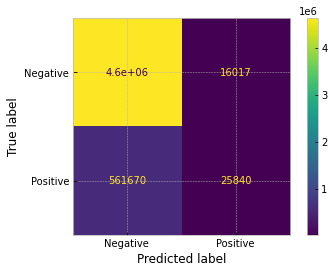

In [81]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(logistic_reg, X_test, y_test, display_labels=['Negative', 'Positive'])

Matríz de confusión sobre datos con **oversampling - SMOTE**

<Figure size 864x288 with 0 Axes>

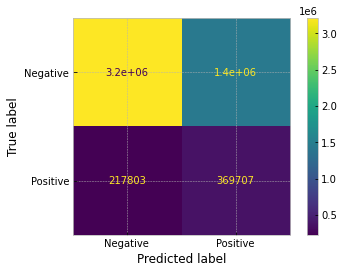

In [82]:
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(logistic_reg_smote, X_test, y_test, display_labels=['Negative', 'Positive'])

Reporte de Precision - Recall - F1 Score | **Datos sin oversampling - SMOTE**

In [83]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   4648777
         1.0       0.62      0.04      0.08    587510

    accuracy                           0.89   5236287
   macro avg       0.75      0.52      0.51   5236287
weighted avg       0.86      0.89      0.84   5236287



Reporte de Precision - Recall - F1 Score | **Datos con oversampling - SMOTE**

In [84]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds_over))

              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80   4648777
         1.0       0.21      0.63      0.31    587510

    accuracy                           0.68   5236287
   macro avg       0.57      0.66      0.55   5236287
weighted avg       0.85      0.68      0.74   5236287



**Resultados**

Para este caso particular, vemos que el modelo de **regresión logística**, bajo la implementación de **SMOTE** presenta buen performance en términos de generalización de la clase 0 y la clase 1. El F1 score de la clase 1 pasa de 0.08  a 0.31, por lo que vemos una mejor en este indicador, sacrificando el buen prevision que teníamos y aumentando el recall. Nuestro accuracy baja de **0.89** a **0.69** bajo el uso de **SMOTE**.

En base a lo comentado previamente, se recomienda entrena el modelo bajo el uso de **oversampling (SMOTE)**.

**ROC Curve | Datos con oversampling - SMOTE y Datos sin Oversampling**


0.7159691372629268 0.7191247183944047


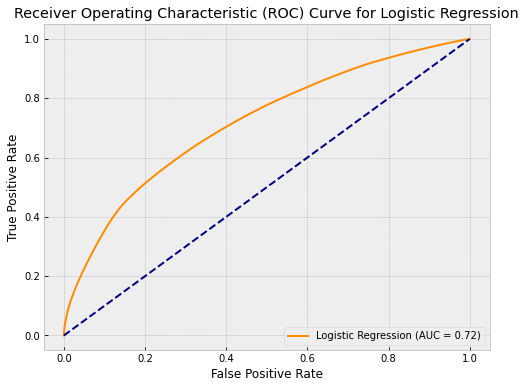

In [85]:
y_scores_tree_no = logistic_reg.predict_proba(X_test)
y_scores_tree_wo = logistic_reg_smote.predict_proba(X_test)

fpr_tree_no, tpr_tree_no, thresholds_tree_no = roc_curve(y_test, y_scores_tree_no[:,1])
roc_auc_tree_no = auc(fpr_tree_no, tpr_tree_no)   # Este es el indicador AUC de la curva ROC

fpr_tree_wo, tpr_tree_wo, thresholds_tree_wo = roc_curve(y_test, y_scores_tree_wo[:,1])
roc_auc_tree_wo = auc(fpr_tree_wo, tpr_tree_wo)   # Este es el indicador AUC de la curva ROC

print(roc_auc_tree_no, roc_auc_tree_wo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_no, tpr_tree_no, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_tree_no:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

El gráfico anterior muestra el indicador **AUC** de la curva **ROC** con un valor de 0.72, lo cual, tiene buen performance en cuanto a la diferenciación de las dos clases: **"Churn"** y **"No Churn"**. 

### **Cross Validation y Curva ROC (Ejercicios de prueba)**

**Implementación de cross validation**

En esta sección estarémos implementando cross validations para  el diagnóstico de la varianza de nuestro modelo, comprobar si tenemos un modelo de alta varianza debido a que en la validación simple utilizamos solo una muestra aleatoria de nuestros datos paricular.

El utilizaremos dos enfoques, **Cross Validation** y **Stratified Cross Validation** y comparamos ambos enfoques.

**Simple K Fold con Cross validation sobre datos sin oversampling**


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

kfold = KFold(n_splits=7, shuffle=True, random_state=1) #Creamos el conjunto de validación

clf= DecisionTreeClassifier(
    criterion='gini',
    max_depth=8,
    min_samples_split=8,
    min_samples_leaf=1,
    max_features=None,
    splitter='best',
    random_state=1234
)

scores_f1 = cross_val_score(clf, X_train, y_train, scoring='f1', cv = kfold)  
scores_acc = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv = kfold)  

print(scores_f1,scores_acc)

[0.13974561 0.12501171 0.1300184  0.12430892 0.12012624 0.12571738
 0.13271378] [0.89098225 0.89076902 0.89109922 0.89116506 0.8911704  0.89104671
 0.89127397]


**Stratifield Cross validation sobre datos sin oversampling**


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

skf = StratifiedKFold(n_splits=7, random_state=42, shuffle=True)
skf.get_n_splits(X_train, y_train)

clf= DecisionTreeClassifier(
    criterion='gini',
    max_depth=8,
    min_samples_split=8,
    min_samples_leaf=1,
    max_features=None,
    splitter='best',
    random_state=1234
)

accuracy_list = list()
precision_list = list()
recall_list = list()
f1_list = list()

for i in range(0,skf.get_n_splits(X_train, y_train)):
  train, test = list(skf.split(X_train, y_train))[i]
  X_train_n, y_train_n, X_test_n, y_test_n= X_train[train], y_train[train], X_train[test],y_train[test]
  clf.fit(X_train_n, y_train_n)
  pred = clf.predict(X_test_n)
  
  # Calculo parámetros de evaluación de modelo
  accuracy = accuracy_score(y_true=y_test_n, y_pred= pred)
  precision = precision_score(y_true=y_test_n, y_pred= pred)
  recall = recall_score(y_true=y_test_n, y_pred= pred)
  f1_scor = f1_score(y_true=y_test_n, y_pred= pred)
  
  accuracy_list.append(accuracy)
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1_scor)
  
  print('Iteracion:',i+1, ' Accuracy:', accuracy, ' Precision:',precision, ' Recall:',recall, ' f1:', f1_scor)

Iteracion: 1  Accuracy: 0.8911039071097605  Precision: 0.6445829570733211  Recall: 0.06236122889933475  f1: 0.11372039300487079
Iteracion: 2  Accuracy: 0.8910847836097577  Precision: 0.6183943089430894  Recall: 0.07261073477989419  f1: 0.1299616133455123
Iteracion: 3  Accuracy: 0.891150670000136  Precision: 0.6369035386954913  Recall: 0.06604133416578414  f1: 0.1196735648960632
Iteracion: 4  Accuracy: 0.8910740412635004  Precision: 0.6112099339787227  Recall: 0.07614564732856309  f1: 0.13542037728984926
Iteracion: 5  Accuracy: 0.8909986061208934  Precision: 0.6372091011333161  Recall: 0.06277887397772844  f1: 0.11429702017713672


**Curva ROC** 

El indicador AUC de la curva ROC es un elemento importante para la medición del performance del modelo respecto a la capacidad de diferenciar dos clases dado un problema de **clasificación binario**. El indicador AUC, entre más cerca se encuentre de 1, tendrá buen rendimiento en diferencias las clases en cuestión. Dicho esto, se considera un buen modelo aquel que tiene un **AUC mayor o igual a 0.7**.

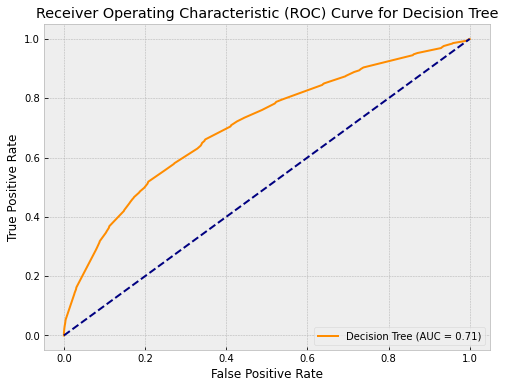

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

clf= DecisionTreeClassifier(
    criterion='gini',
    max_depth=8,
    min_samples_split=8,
    min_samples_leaf=1,
    max_features=None,
    splitter='best',
    random_state=1234
)

clf_no = clf.fit(X_train, y_train)
clf_wo = clf.fit(X_train_over, y_train_over)

y_scores_tree_no = clf_no.predict_proba(X_test)
y_scores_tree_wo = clf_wo.predict_proba(X_test)


fpr_tree_no, tpr_tree_no, thresholds_tree_no = roc_curve(y_test, y_scores_tree_no[:,1])
roc_auc_tree_no = auc(fpr_tree_no, tpr_tree_no)   # Este es el indicador AUC de la curva ROC

fpr_tree_wo, tpr_tree_wo, thresholds_tree_wo = roc_curve(y_test, y_scores_tree_wo[:,1])
roc_auc_tree_wo = auc(fpr_tree_wo, tpr_tree_wo)   # Este es el indicador AUC de la curva ROC

print(roc_auc_tree_no,roc_auc_tree_wo)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree_no, tpr_tree_no, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_tree_no:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

### **Hyperparameter tunning con Cross Validation y curva ROC**

En la siguiente sección, realizaremos el entrenamiento de los modelos de ML a través de Grid Search CV y el uso de un conjunto de validación para ver el performance de las métricas.

Grid Search CV es un método de fuerza bruta, por lo que los tiempos de ejecución se espera que sean altos en comparación contra otros métodos como **Randomized Grid Search**. Los ejercicios se realizarán sobre la base sin SMOTE y se utilizará el **indicador F1 Score** para el conjunto de **cross validation**. También, se especifican aquellos parámetros donde le método entrenará los algoritmos y determinar la mejor combinación que guíe al **mejor performance de F1 Score**.

#### **Grid Search CV | Decision trees**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.model_selection import StratifiedKFold,GridSearchCV, RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv


param_grid = {
    'max_depth': [4,8,10],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,3,4],
    'splitter': ['best'], 
    'criterion' : ['gini','entropy']
}

clf = DecisionTreeClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
grid_search = GridSearchCV(clf, param_grid, scoring='f1', cv=stratified_kfold)
grid_search.fit(X_train,y_train)

best_model = grid_search.best_estimator_

y_pred_best_model = best_model.predict(X_test)
y_proba_best_model = best_model.predict_proba(X_test)

f1_score_ = f1_score(y_test, y_pred_best_model)

f1_best_tree = f1_score(y_test, y_pred_best_model)
precision_best_tree = precision_score(y_test, y_pred_best_model)
recall_best_tree = recall_score(y_test, y_pred_best_model)
accuracy_best_tree  = accuracy_score(y_test,y_pred_best_model)

#ROC Curve
fpr_best_model, tpr_best_model, thresholds_best_model = roc_curve(y_test, y_proba_best_model[:,1])
roc_auc_best_model = auc(fpr_best_model, tpr_best_model)   # Este es el indicador AUC de la curva ROC

print(f'F1 score:{f1_best_tree:.2f} | Precision score:{precision_best_tree:.2f} | Recall score:{recall_best_tree:.2f} | Accuracy score:{accuracy_best_tree:.2f} | ROC Curve: {roc_auc_best_model:.2f}')

print('Best Hyperparameters:')
print(grid_search.best_params_)

F1 score:0.14 | Precision score:0.58 | Recall score:0.08 | Accuracy score:0.89 | ROC Curve: 0.72
Best Hyperparameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


Cómo se observa, los siguientes parámetros son los que dieron los mejores resultados en función del **F1 Score: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}**

Reporte de performance de métricas **sin Oversampling | SMOTE**

In [ ]:
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = best_model.predict(X_test)

print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94   4648777
         1.0       0.58      0.08      0.14    587510

    accuracy                           0.89   5236287
   macro avg       0.74      0.54      0.54   5236287
weighted avg       0.86      0.89      0.85   5236287



#### **Grid Search CV | Logistic Regression** 


In [ ]:
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,GridSearchCV, RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv


param_grid = {
    'penalty': ['none','l2'],
    'C' : [1,0.1,10],
    'class_weight': ['balanced']
}

log_reg = LogisticRegression(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, scoring='f1', cv=stratified_kfold)
grid_search.fit(X_train,y_train)

best_model = grid_search.best_estimator_

y_pred_best_model = best_model.predict(X_test)
y_proba_best_model = best_model.predict_proba(X_test)

f1_score_ = f1_score(y_test, y_pred_best_model)

f1_best_tree = f1_score(y_test, y_pred_best_model)
precision_best_tree = precision_score(y_test, y_pred_best_model)
recall_best_tree = recall_score(y_test, y_pred_best_model)
accuracy_best_tree  = accuracy_score(y_test,y_pred_best_model)

#ROC Curve
fpr_best_model, tpr_best_model, thresholds_best_model = roc_curve(y_test, y_proba_best_model[:,1])
roc_auc_best_model = auc(fpr_best_model, tpr_best_model)   # Este es el indicador AUC de la curva ROC

print(f'F1 score:{f1_best_tree:.2f} | Precision score:{precision_best_tree:.2f} | Recall score:{recall_best_tree:.2f} | Accuracy score:{accuracy_best_tree:.2f} | ROC Curve: {roc_auc_best_model:.2f}')

print('Best Hyperparameters:')
print(grid_search.best_params_)

F1 score:0.31 | Precision score:0.21 | Recall score:0.63 | Accuracy score:0.69 | ROC Curve: 0.72
Best Hyperparameters:
{'C': 1, 'class_weight': 'balanced', 'penalty': 'none'}


Cómo se observa, los siguientes parámetros son los que dieron los mejores resultados en función del **F1 Score: {'C': 1, 'class_weight': 'balanced', 'penalty': 'none'}**

Reporte de performance de métricas **sin Oversampling | SMOTE**

In [ ]:
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = best_model.predict(X_test)

print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80   4648777
         1.0       0.21      0.63      0.31    587510

    accuracy                           0.69   5236287
   macro avg       0.57      0.66      0.56   5236287
weighted avg       0.85      0.69      0.75   5236287



#### **Grid Search CV | Xgboost** 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,GridSearchCV, RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv


param_grid = {
    'max_depth': [2,6,8],
    'n_estimators' : [50,150,200],
    'learning_rate': [0.1,0.2,0.01]
}

xgb_model = xgb.XGBClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, scoring='f1', cv=stratified_kfold)
grid_search.fit(X_train,y_train)

best_model = grid_search.best_estimator_

y_pred_best_model = best_model.predict(X_test)
y_proba_best_model = best_model.predict_proba(X_test)

f1_score_ = f1_score(y_test, y_pred_best_model)

f1_best_tree = f1_score(y_test, y_pred_best_model)
precision_best_tree = precision_score(y_test, y_pred_best_model)
recall_best_tree = recall_score(y_test, y_pred_best_model)
accuracy_best_tree  = accuracy_score(y_test,y_pred_best_model)

fpr_best_model, tpr_best_model, thresholds_best_model = roc_curve(y_test, y_proba_best_model[:,1])
roc_auc_best_model = auc(fpr_best_model, tpr_best_model)   # Este es el indicador AUC de la curva ROC

print(f'F1 score:{f1_best_tree:.2f} | Precision score:{precision_best_tree:.2f} | Recall score:{recall_best_tree:.2f} | Accuracy score:{accuracy_best_tree:.2f} | ROC Curve: {roc_auc_best_model:.2f}')

print('Best Hyperparameters:')
print(grid_search.best_params_)

F1 score:0.14 | Precision score:0.63 | Recall score:0.08 | Accuracy score:0.89 | ROC Curve: 0.73
Best Hyperparameters:
{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}


Cómo se observa, los siguientes parámetros son los que dieron los mejores resultados en función del **F1 Score: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}**

Reporte de performance de métricas **sin Oversampling | SMOTE**

In [ ]:
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = best_model.predict(X_test)

print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94   4648777
         1.0       0.63      0.08      0.14    587510

    accuracy                           0.89   5236287
   macro avg       0.76      0.54      0.54   5236287
weighted avg       0.87      0.89      0.85   5236287



### **Conclusión de entrenamiento, evaluación y selección de modelos de Machine Learning**


A través del entrenamiento de diferentes modelos de Machine Learning, podemos tomar aquel con el mejor performance en términos de predicción de la variable objetivo.

Los modelos de árboles fueron preferentemente seleccionados dado su rápida **implementación y flexibilidad** para el manejo de datos atípicos como **XGboost** o **Random Forests**, sin embargo, esto no sucede en modelos de árboles simples o en logistic regression. También, la implementación de métodos de validación cómo cross validation nos permite reducir el efecto de **“Overfitting”** y tener una mejor visibilidad del performance real de nuestro modelo sobre diferentes subconjuntos del dataset.

Respecto a cuál modelo debemos elegir, dado que nuestro interés es predecir **cuales tienen mayor probabilidad de Churn**, tomaremos aquel con mayor precision y recall sobre la clase “Churn”. Así, tomamos el modelo “**XGBoost variante A sin SMOTE (validación simple)**. Tiene buen precision, recall y f1 score, así como buen performance de estos mismos indicadores sobre la clase “No Churn”.

Se mantiene buen **AUC** de **0.67** y un accuracy de **83%**. Debemos tener cuidado sobre este último por el problema de desbalanceo, sin embargo, la aplicación de oversampling no contribuyó a la mejora de dicho modelo. Adicionalmente, recomendámos realizar pruebas sobre otra malla de parámetros de **Grid Search CV**. 



### **Apéndice: Entrenamiento del modelo de Machine Learning (XGBoost) con metodo de reducción de dimensiones: componentes principales**



Dentro del modelo de ML, utilizaremos el modelo XGBoost para entrenar nuestro modelo con solo **dos componentes principales del PCA**, los cuales, agruparían el 80% de la varianza del data set original.

Cabe remarcar que para este ejercicio usaremos la información **sin oversampling con SMOTE**.

#### **Feature extraction: Reducción de dimensionalidad**

Dentro del proceso de feature engineering, en el pasado, tuvimos la oportunidad de utilizar **Backward and Forward elimination** para seleccionar las variables más relevantes dentro de nuestro modelo de Machine Learning a través de la métrica de F1 Score. Este método formó parte del proceso de **"Feature Selection"** del tipo **"Wrapper methods"**.

En la siguiente sección, utilizaremos un modelo Basado en **Feature Extraction**, el cual, extrae variables relevantes como una combinación lineal de las variables originales con menor número de dimensiones. **El método a utilizar será PCA**. 

En la siguiente sección, utilizaremos el modelo seleccionado en la sección anterior denominado **XGBoost** para entrenar nuestro modelo de machine learning con variables procesadas a través de **PCA**. Para este caso particular, utilizaremos los datos sin **OVERSAMPLING - SMOTE** para aplicar la técnica de reducción de dimensionalidad.  

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Análisis de la varianza explicada para cada componente. 

In [ ]:
#Análisis de la varianza explicada para cada componente
explained_variance = pca.explained_variance_ratio_
explained_variance

array([6.53005472e-01, 1.53514893e-01, 1.03007667e-01, 8.41313046e-02,
       5.52523427e-03, 6.10655012e-04, 1.68298537e-04, 3.64757637e-05])

**Insight**: De la matriz de exploración de la explicación de varianza, vemos que los **primeros dos componentes**, en conjunto, explican alrededor del **80% de la varianza del conjunto de datos original**.

El tercero **explica un 10% de la varianza**, el cuarto componente explica solo **8%** y así consecutivamente. 

A continuación, realizarémos el entrenamiento de nuestro modelo con la **curva ROC**.

In [15]:
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import metrics


#Obtenemos solo los dos principales componentes
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Entrenamos el modelo sobre la base de información imbalanceada
xgb_model =  xgb.XGBClassifier(learning_rate = 0.1, random_state = 42)

#We train over the data set that is not oversampled.
xgb_model_no = xgb_model.fit(X_train_pca, y_train)


Evaluación del modelo de clasifiación **XGBoost** con las nuevas variables del **PCA**.

In [16]:
# Guardamos los valores reales del conjunto de entrenamiento y  
predictions = pd.DataFrame()
predictions['true'] = y_train
predictions['preds'] = xgb_model_no.predict(X_train_pca)

# Test set
predictions_test = pd.DataFrame()
predictions_test['true'] = y_test
predictions_test['preds'] = xgb_model_no.predict(X_test_pca)

# Calculamos el accuracy 
train_acc = accuracy_score(predictions.true, predictions.preds)
test_acc = accuracy_score(predictions_test.true, predictions_test.preds)

print(f"Accuary datos entrenamiento: {train_acc:.4f}, Accuracy datos Test: {test_acc:.4f}")

Accuary datos entrenamiento: 0.8883, Accuracy datos Test: 0.8881


Matriz de confusión

<Figure size 864x288 with 0 Axes>

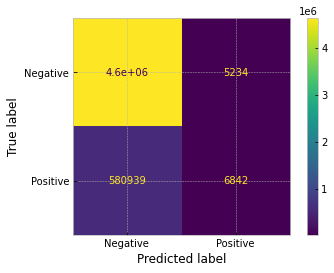

In [17]:
# Graficamos una matriz de confusión
plt.figure(figsize=(12,4))
metrics.plot_confusion_matrix(xgb_model_no, X_test_pca, y_test, display_labels=['Negative', 'Positive'])

Reporte de Precision - Recall - F1 Score | **Datos sin oversampling - SMOTE**

In [18]:
print(metrics.classification_report(predictions_test.true, predictions_test.preds))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   4648506
         1.0       0.57      0.01      0.02    587781

    accuracy                           0.89   5236287
   macro avg       0.73      0.51      0.48   5236287
weighted avg       0.85      0.89      0.84   5236287



De acuerdo con el reporte anterior, la implementación de **PCA** en nuestro modelo, en términos de **F1 Score para la clase 1 ("No Churn")**, tiene **los resultados más bajos** si se compara contra los demás modelos donde se utilizaba el conjutno de **datos originales**. Dicho esto, no se recomienda la utilización de PCA, al menos para este caso, para el entrenamiento de nuestro modelo de predicción de **Churn**. 